# Determining quantum bounds for a parametric Bell expression

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ncpol2sdpa import generate_variables, SdpRelaxation
from scipy.optimize import minimize_scalar

# 1. Define quantum operators: A0, A1 for Alice, B0, B1 for Bob
A = [generate_variables(f"A{i}", 1)[0] for i in range(2)]
B = [generate_variables(f"B{i}", 1)[0] for i in range(2)]
ops = A + B

# 2. Add operator constraints (e.g., projective measurements: A_i^2 = 1, etc.)
op_eqs = [op**2 - 1 for op in ops]  # A_i^2 = B_j^2 = I
op_ineqs = []  # if any
moment_eqs = []
moment_ineqs = []

In [ ]:
s = np.sqrt(2)

# 3. Helper to compute quantum value of Bell expression at (p1, p4)
def compute_beta(p1, p4, Theta):
    
    beta_expr = 1/16*(4*(s*(B[0] + B[1])*1/np.tan(2*Theta)*1/np.sin(2*Theta) + 4*p1*A[0]+ 8*p4*A[1]) + (4/s)*1/np.sin(2*Theta)**2*((B[0] + B[1])*(-3 + np.cos(4*Theta))*p1 - 2*A[0]*B[0]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) - 2*A[0]*B[1]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) + 
    2*np.sin(2*Theta)*(4*(-B[0] + B[1])*p4*np.sin(2*Theta)**2 + A[1]*B[1]*(-1 + np.cos(2*Theta)*p1 - 2*p4*np.sin(4*Theta)) - A[1]*B[0]*(-1 + np.cos(2*Theta)*p1 + 2*p4*np.sin(4*Theta)))))

    sdp = SdpRelaxation(ops, verbose=0)
    sdp.get_relaxation(
        level=2,
        equalities=op_eqs,
        inequalities=op_ineqs,
        momentequalities=moment_eqs,
        momentinequalities=moment_ineqs,
        objective=-beta_expr  # maximize beta ⇒ minimize -beta
    )
    sdp.solve(solver="mosek")
    return -sdp.dual  # return max value of β

# 4. Minimize r such that β(p1, p4) ≥ 1
def minimize_r(phi, Theta):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4, Theta)
        return r if beta >= 1 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

In [ ]:
theta = np.pi/4

phis = np.linspace(0, np.pi, 200)
boundary = []

for phi in phis:
    point = minimize_r(phi, theta)
    if point:
        boundary.append(point)

boundary = np.array(boundary)

In [ ]:
mirrored_boundary = boundary.copy()
mirrored_boundary[:, 1] *= -1  # Flip p4

# Combine original and mirrored boundaries
full_boundary = np.vstack([boundary, mirrored_boundary[::-1]])  # Optional reverse for continuity

# Plot
plt.figure(figsize=(6, 6))
plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
plt.xlabel(r"$p_1$", fontsize=14)
plt.ylabel(r"$p_4$", fontsize=14)
plt.title("Quantum Set Boundary", fontsize=16)
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

## Parallelization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ncpol2sdpa import generate_variables, SdpRelaxation
from scipy.optimize import minimize_scalar
from joblib import Parallel, delayed

In [ ]:
# Quantum operator setup
A = [generate_variables(f"A{i}", 1)[0] for i in range(2)]
B = [generate_variables(f"B{i}", 1)[0] for i in range(2)]
ops = A + B

op_eqs = [op**2 - 1 for op in ops]
op_ineqs = []
moment_eqs = []
moment_ineqs = []
s = np.sqrt(2)

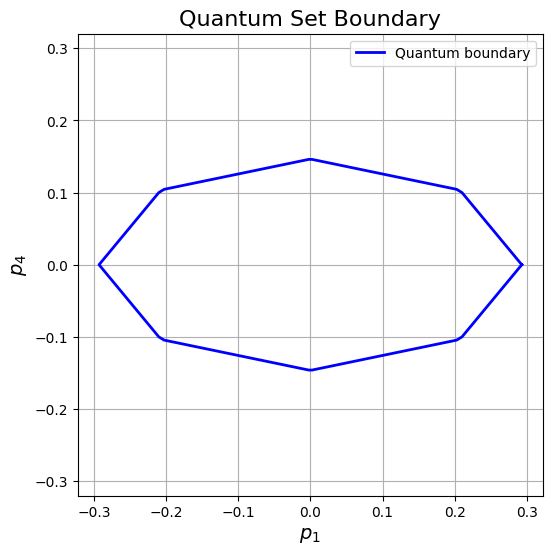

In [ ]:
Theta = np.pi / 4

def compute_beta(p1, p4):
    beta_expr = 1/16*(4*(s*(B[0] + B[1])*1/np.tan(2*Theta)*1/np.sin(2*Theta) + 4*p1*A[0]+ 8*p4*A[1]) + 
        (4/s)*1/np.sin(2*Theta)**2*((B[0] + B[1])*(-3 + np.cos(4*Theta))*p1 - 
        2*A[0]*B[0]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) - 
        2*A[0]*B[1]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) + 
        2*np.sin(2*Theta)*(4*(-B[0] + B[1])*p4*np.sin(2*Theta)**2 + 
        A[1]*B[1]*(-1 + np.cos(2*Theta)*p1 - 2*p4*np.sin(4*Theta)) - 
        A[1]*B[0]*(-1 + np.cos(2*Theta)*p1 + 2*p4*np.sin(4*Theta)))))
    
    sdp = SdpRelaxation(ops, verbose=0)
    sdp.get_relaxation(
        level=2,
        equalities=op_eqs,
        inequalities=op_ineqs,
        momentequalities=moment_eqs,
        momentinequalities=moment_ineqs,
        objective=-beta_expr
    )
    sdp.solve(solver="mosek")
    return -sdp.dual

def minimize_r(phi):
    def objective(r):
        if r < 0:
            return np.inf
        p1 = r * np.cos(phi)
        p4 = r * np.sin(phi)
        beta = compute_beta(p1, p4)
        return r if beta >= 1 else np.inf

    res = minimize_scalar(objective, bounds=(0, 1), method='bounded')
    if res.success and np.isfinite(res.fun):
        r = res.x
        return r * np.cos(phi), r * np.sin(phi)
    else:
        return None

if __name__ == "__main__":
    phis = np.linspace(0, np.pi, 100)

    # Use all available cores by default
    results = Parallel(n_jobs=-1, backend="loky")(delayed(minimize_r)(phi) for phi in phis)
    boundary = np.array([pt for pt in results if pt is not None])

    # Mirror with respect to p4 → -p4
    mirrored = boundary * np.array([1, -1])
    full_boundary = np.vstack([boundary, mirrored[::-1]])

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(full_boundary[:, 0], full_boundary[:, 1], 'b-', lw=2, label="Quantum boundary")
    plt.xlabel(r"$p_1$", fontsize=14)
    plt.ylabel(r"$p_4$", fontsize=14)
    plt.title("Quantum Set Boundary", fontsize=16)
    plt.grid(True)
    plt.axis("equal")
    plt.legend()
    plt.show()

## Different forms of our Bell expression 

In [ ]:
Theta = np.pi/8
s = np.sqrt(2)
p1 = 0
p4 = 1

obj = 1/16*p1*(16*A[0] - 4*s*B[1] - s*B[1]*1/(np.sin(Theta))**2 + 2*s*B[0]*(-3 + np.cos(4*Theta))*1/np.sin(2*Theta)**2 + 4*s*1/np.tan(2*Theta)*1/np.sin(2*Theta)*A[0]*B[0] + 4*s*1/np.tan(2*Theta)*1/np.sin(2*Theta)*A[0]*B[1] - 4*s*1/np.tan(2*Theta)*A[1]*B[0] + 4*s*1/np.tan(2*Theta)*A[1]*B[1] - s*B[1]*1/np.cos(Theta)**2) + 1/16*(s*B[1]*1/np.sin(Theta)**2 + 4*s*B[0]*1/np.tan(2*Theta)*1/np.sin(2*Theta) - 4*s*np.cos(4*Theta)*1/np.sin(2*Theta)^2*A[0]*B[0] - 4*s*np.cos(4*Theta)*1/np.sin(2*Theta)**2*A[0]*B[1] + 4*s*1/np.sin(2*Theta)*A[1]*B[0] - 4*s*1/np.sin(2*Theta)*A[1]*B[1] - s*B[1]*1/np.cos(Theta)**2) + 1/16*p4*(32*A[1] + 16*s*B[1]*np.sin(2*Theta) - 16*s*B[0]*np.sin(2*Theta) - 8*s*1/np.sin(2*Theta)*A[1]*B[0]*np.sin(4*Theta) - 8*s*1/np.sin(2*Theta)*A[1]*B[1]*np.sin(4*Theta))

In [ ]:
obj = 1/16*(4*(s*(B[0] + B[1])*1/np.tan(2*Theta)*1/np.sin(2*Theta) + 4*p1*A[0]+ 8*p4*A[1]) + (4/s)*1/np.sin(2*Theta)**2*((B[0] + B[1])*(-3 + np.cos(4*Theta))*p1 - 2*A[0]*B[0]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) - 2*A[0]*B[1]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) + 
2*np.sin(2*Theta)*(4*(-B[0] + B[1])*p4*np.sin(2*Theta)**2 + A[1]*B[1]*(-1 + np.cos(2*Theta)*p1 - 2*p4*np.sin(4*Theta)) - A[1]*B[0]*(-1 + np.cos(2*Theta)*p1 + 2*p4*np.sin(4*Theta)))))

# Bancal's method

In [ ]:
# Define quantum operators
A = [generate_variables(f"A{i}", 1)[0] for i in range(2)]
B = [generate_variables(f"B{i}", 1)[0] for i in range(2)]
r = generate_variables('r', hermitian=True, commutative=True)[0]
ops = A + B

Theta = np.pi/4
phi = 0
s = np.sqrt(2)
p1 = r*np.cos(phi)
p4 = r*np.sin(phi)

beta_expr = 1/16*(4*(s*(B[0] + B[1])*1/np.tan(2*Theta)*1/np.sin(2*Theta) + 4*p1*A[0]+ 8*p4*A[1]) + (4/s)*1/np.sin(2*Theta)**2*((B[0] + B[1])*(-3 + np.cos(4*Theta))*p1 - 2*A[0]*B[0]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) - 2*A[0]*B[1]*(np.cos(4*Theta) - p1*np.cos(2*Theta)) + 
2*np.sin(2*Theta)*(4*(-B[0] + B[1])*p4*np.sin(2*Theta)**2 + A[1]*B[1]*(-1 + np.cos(2*Theta)*p1 - 2*p4*np.sin(4*Theta)) - A[1]*B[0]*(-1 + np.cos(2*Theta)*p1 + 2*p4*np.sin(4*Theta)))))


# Constraints
op_eqs = [op**2 - 1 for op in ops]
op_ineqs = [r]
moment_eqs = []
moment_ineqs = [beta_expr - 1]

# Compute quantum value of Bell expression at (p1, p4) for a given Thet

sdp = SdpRelaxation(ops + [r], verbose=0)
sdp.get_relaxation(
    level=2,
    equalities=op_eqs,
    inequalities=op_ineqs,
    momentequalities=moment_eqs,
    momentinequalities=moment_ineqs,
    objective=r
)
sdp.solve(solver="mosek")
print(sdp.primal)